# Setup environment

If you haven't already, make sure to install packages required to execute code inside this notebook. For detailed instructions go to the repository README section.

# Import required packages

In [29]:
from pathlib import Path
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchaudio.transforms import MelSpectrogram
from speechbrain.lobes.models.ECAPA_TDNN import ECAPA_TDNN
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger

# Task

This notebook provides a template for training speaker verification models in a self-supervised contrastive manner. We will use a small subset of the VoxCeleb dataset for demonstration purposes. The presented framework can be extended to other models and datasets.

The main idea of self-supervised contrastive learning is presented on the diagram below:

![title](resources/contrastive.png)

In order to obtain such framework we have to develop the following components:

1. Data loading/preprocessing pipeline.
2. Model architecture.
3. Loss function.
4. Training/validation loop.

# CONFIG

Here, we define config variables used for initializing pipeline components:

In [30]:
DATA_DIR = Path("./resources/data")
SAMPLE_RATE = 16_000
SEGMENT_LENGTH = 48_000
SAMPLES_PER_EPOCH = 1_000
NUM_MELS = 80
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
DEVICE = "cpu"
NUM_WORKERS = 4
NUM_EPOCHS = 10

# if you have a GPU choose it's ID
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
DEVICE = "cuda"

# Data loading/preprocessing pipeline

We are going to use the Normalized Temperature-Scaled Cross Entropy (NTXent) loss function. That means the PyTorch dataset has to return one positive pair per iteration. A positive pair will be defined as 2 random crops from the same audio file. In contrast, a negative pair will be defined as 2 crops from 2 different audio files (one from each). The negative pairs will be constructed between different entries within a batch.

We will use the Short-Time Fourier Transform (STFT) combined with a mel-scale filter to preprocess our data. After this preprocessing step, we will obtain a 2D spectrogram as an input to our neural network. We can treat spectrograms similarly to images, keeping in mind the relationship between time and frequency axes.

![title](resources/audio_processing.png)

Image source: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5</figcaption>

Let's define a PyTorch dataset class to handle data loading, cropping and transforming to spectrograms.

In [3]:
class VoxCelebContrastiveDataset(Dataset):
    def __init__(
        self,
        dir_path: str,
        sample_rate: int,
        segment_length: int,
        samples_per_epoch: int,
    ):
        self.dir_path = Path(dir_path)
        self.all_filenames = list(dir_path.glob("**/*.wav"))
        self.sample_rate = sample_rate
        self.segment_length = segment_length
        self.samples_per_epoch = samples_per_epoch

        self.feature_extractor = MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=NUM_MELS,
            power=1
        )       

    def __len__(self):
        return self.samples_per_epoch

    def _crop_or_pad(self, audio, segment_length):
        diff = audio.shape[-1] - segment_length
    
        if diff > 0:
            offset = np.random.randint(low=0, high=diff)
            output = audio[:, offset : offset + segment_length]
        elif diff < 0:
            diff *= -1
            left_pad = np.random.randint(low=0, high=diff)
            right_pad = diff - left_pad
            pad = (left_pad, right_pad)
            output = F.pad(audio, pad)
        else:
            output = audio

        return output

    def _get_crops(self, audio):
        # get 2 random crops
        seg1 = self._crop_or_pad(audio, self.segment_length)
        seg2 = self._crop_or_pad(audio, self.segment_length)

        return seg1, seg2

    def __getitem__(self, index):
        filename = random.choice(self.all_filenames)
        audio, sr = torchaudio.load(filename, channels_first=True, backend="soundfile")

        if sr != self.sample_rate:
            audio = F.resample(audio, orig_freq=sr, new_freq=self.sample_rate)

        crop1, crop2 = self._get_crops(audio)

        features1 = self.feature_extractor(crop1).permute(0, 2, 1)
        features2 = self.feature_extractor(crop2).permute(0, 2, 1)

        stacked_features = torch.cat([features1, features2], dim=0)
        stacked_audios = torch.cat([crop1, crop2], dim=0)

        return stacked_features, stacked_audios

In [4]:
train_dataset = VoxCelebContrastiveDataset(
    dir_path=DATA_DIR / "train",
    sample_rate=SAMPLE_RATE,
    segment_length=SEGMENT_LENGTH,
    samples_per_epoch=SAMPLES_PER_EPOCH,
)

valid_dataset = VoxCelebContrastiveDataset(
    dir_path=DATA_DIR / "valid",
    sample_rate=SAMPLE_RATE,
    segment_length=SEGMENT_LENGTH,
    samples_per_epoch=SAMPLES_PER_EPOCH,
)

After defining the dataset class, we have to wrap it into a PyTorch DataLoader module.

In [5]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False
)

# Model architecture

For our model we will import the ECAPA-TDNN model implemented in the speechbrain package. It is a convolutional Time Delay Neural Network (TDNN) showing state-of-the-art performance in the speaker verification task. It is worth noting that the model component is interchangable, and we can define any model we like as long as it processes input data provided by the dataloader (shape: `[batch, time, features]`) , and returns an embedding of the same shape structure as ECAPA-TDNN i.e. `[1, embedding_size]`.

Details about the model can be found in the original paper *"ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation
in TDNN Based Speaker Verification"* by Desplanques et al. The block diagram of the architecture looks as follows (image from the paper):

![title](resources/ecapa.png)

In [6]:
model = ECAPA_TDNN(
    input_size=NUM_MELS,
    channels=[256, 256, 256, 256, 768],
    device=DEVICE
)

# Loss function

As mentioned before, we will use the NTXent loss function initially introduced in *"A Simple Framework for Contrastive Learning of Visual Representations"* by Chen et al.

The version we will implement is adapted from `https://github.com/dhruvbird/ml-notebooks/blob/main/nt-xent-loss/NT-Xent%20Loss.ipynb`. Please visit the link for step-by-step explanation of the loss function. In the simplest terms, this loss function calculates a similarity matrix between all samples within the batch and applies cross entropy on each row of the matrix (there is one positive and multiple negative pairs in each row). Our implementation will include the option to learn the temperature parameter.

We will also implement a helper `contrastive_accuracy` function to track metrics during training.

In [7]:
def contrastive_accuracy(sim_matrix):
    batch_size = sim_matrix.shape[0]
    r = torch.arange(batch_size, device=sim_matrix.device)

    contr_acc_1 = (sim_matrix.argmax(0) == r).sum() / batch_size
    contr_acc_2 = (sim_matrix.argmax(1) == r).sum() / batch_size
    contr_acc = (contr_acc_1.float() + contr_acc_2.float()) / 2
    return contr_acc


class NTXentLoss(nn.Module):
    """Used in SimCLR. Implementation adapted from:
    https://github.com/dhruvbird/ml-notebooks/tree/main/nt-xent-loss

    Moved temp scaling before self-similarity exlusion to allow
    for trainable temperature (scaling by matrix with -inf resulted
    in temperature=NaN).
    """

    def __init__(
        self,
        temperature: float = 0.1,
        learn_temperature: bool = False,
    ):
        super().__init__()
        if learn_temperature:
            self.temperature = nn.Parameter(torch.tensor(temperature))
        else:
            self.temperature = torch.tensor(temperature)

    def forward(self, emb_a, emb_b):
        # emb_a and emb_b have augmentations of the same sample
        # at corresponding indices
        assert (
            emb_a.shape == emb_b.shape
        ), "Corresponding embs must have identical shapes"
        batch_size = emb_a.shape[0]
        # concatenate embs to maximize pair count (symmetric loss)
        emb_ab = torch.cat((emb_a, emb_b), dim=0)

        # calculate cosine similarity: normalize + matmul
        emb_ab_norm = F.normalize(emb_ab, dim=-1)
        sim_matrix = torch.mm(emb_ab_norm, emb_ab_norm.T)
        # apply temperature scaling
        scaled_sim_matrix = sim_matrix / self.temperature

        # exclude self-similarity
        self_exclusion_mask = torch.eye(2 * batch_size, device=sim_matrix.device).bool()
        sim_matrix_ex = scaled_sim_matrix.masked_fill(self_exclusion_mask, float("-inf"))

        # Ground truth labels
        target = torch.arange(2 * batch_size, device=sim_matrix.device)
        target = torch.roll(target, batch_size)

        loss = F.cross_entropy(sim_matrix_ex, target, reduction="mean")

        with torch.no_grad():
            contr_acc = contrastive_accuracy(sim_matrix[:batch_size, batch_size:])

            metrics = {
                'loss': float(loss.item()),
                'contr_acc': contr_acc,
                'loss_temperature': self.temperature.item()
            }

        return loss, metrics

In [8]:
loss_func = NTXentLoss()

# Training/validation loop

To streamline the training/validation loop code we will use PyTorch Lightning, an extension that takes care of a lot of the boilerplate code and leaves the user with just the essential logic. We will define an SVExperiment class that contains all the necessary code to perform training and validation.

In [9]:
class SVExperiment(pl.LightningModule):
    def __init__(
        self,
        embedding_model: nn.Module,
        loss_func: nn.Module,
        learning_rate: float,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["embedding_model", "loss_func"])

        self.embedding_model = embedding_model
        self.loss_func = loss_func
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.embedding_model(x)

    def _step(self, prefix, batch):
        features, audios = batch

        features1 = features[:, 0]
        features2 = features[:, 1]

        # embedding_model input shape: [batch, time, features]
        embs = self.embedding_model(torch.cat([features1, features2], dim=0))
        # embedding_model output shape: [batch, 1, emb_size]

        emb1, emb2 = torch.split(embs, features.shape[0])

        loss, metrics = self.loss_func(emb1.squeeze(1), emb2.squeeze(1))

        for k, v in metrics.items():
            self.log(
                f"{prefix}/{k}",
                float(v),
                on_step=True,
                on_epoch=True,
                batch_size=len(batch),
                prog_bar=True
            )

        return loss

    def training_step(self, batch):
        return self._step("train", batch)

    def validation_step(self, batch):
        return self._step("valid", batch)

    def configure_optimizers(self):
        opt = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return opt

In [10]:
experiment = SVExperiment(
    embedding_model=model,
    loss_func=loss_func,
    learning_rate=LEARNING_RATE
)

We will also setup a logger to gather our training results.

In [11]:
logger = CSVLogger("logs", name="test_exp")

Now we need to wrap our experiment with the pytorch lightning Trainer class instance.

In [12]:
trainer = pl.Trainer(
            max_epochs=NUM_EPOCHS,
            accelerator=DEVICE,
            devices=1,
            logger=logger,
            log_every_n_steps=10
        )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Run training

To run training we use the trainers inbuilt `fit` method and pass the previously created dataloaders as arguments. 

In [13]:
trainer.fit(experiment, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name            | Type       | Params
-----------------------------------------------
0 | embedding_model | ECAPA_TDNN | 2.0 M 
1 | loss_func       | NTXentLoss | 0     
-----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.200     Total estimated model params size (MB)


Epoch 0: 100%|█| 32/32 [00:04<00:00,  7.44it/s, v_num=0, train/loss_step=0.0235, train/contr_acc_ste
Validation: |                                                                 | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████| 32/32 [00:01<00:00, 18.97it/s]
Epoch 1: 100%|█| 32/32 [00:04<00:00,  6.77it/s, v_num=0, train/loss_step=0.0173, train/contr_acc_ste
Validation: |                                                                 | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████| 32/32 [00:01<00:00, 18.45it/s]
Epoch 2: 100%|█| 32/32 [00:04<00:00,  7.68it/s, v_num=0, train/loss_step=0.318, train/contr_acc_step
Validation: |                                                                 | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████| 32/32 [00:01<00:00, 16.87it/s]
Epoch 3: 100%|█| 32/32 [00:04<00:00,  7.65it/s, v_num=0, train/loss_step=0.463, train/contr

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 32/32 [00:06<00:00,  4.63it/s, v_num=0, train/loss_step=0.0029, train/contr_acc_ste


# Results

After the training is finished we can plot the results using the saved logs from training.

First, let's read the logs CSV file, and fetch loss and accuracy data.

In [15]:
logs = pd.read_csv("logs/test_exp/version_0/metrics.csv")

In [33]:
train_loss = logs["train/loss_epoch"].dropna()
valid_loss = logs["valid/loss_epoch"].dropna()

train_acc = logs["train/contr_acc_epoch"].dropna()
valid_acc = logs["valid/contr_acc_epoch"].dropna()

epochs = np.arange(NUM_EPOCHS) + 1

Now let's plot the fetch results.

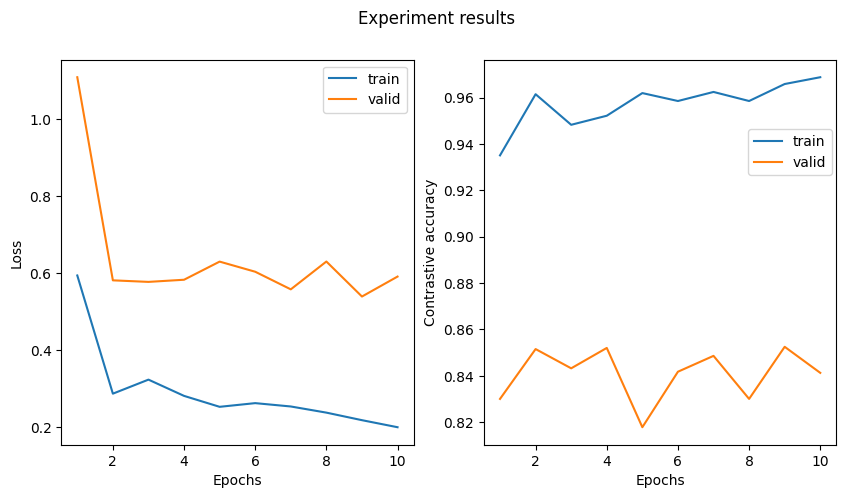

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Experiment results')

ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")

ax1.plot(epochs, train_loss, label="train")
ax1.plot(epochs, valid_loss, label="valid")
ax1.legend(loc="upper right")

ax2.set_ylabel("Contrastive accuracy")
ax2.set_xlabel("Epochs")

ax2.plot(epochs, train_acc, label="train")
ax2.plot(epochs, valid_acc, label="valid")
ax2.legend(loc=(0.75, 0.7))

plt.show()

# Conclusion

Due to the fact that the experiment was carried out on a very small dataset, the results got pretty good very quickly, however the model would not generalize very well. We could use the whole VoxCeleb dataset and train it for a longer time to obtain much better real-life results.  